## Deployment and inference for Keras CV YOLOv8 with TF SavedModel

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow_serving.apis import predict_pb2, prediction_service_pb2_grpc
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
from keras_cv import layers
import numpy as np
import grpc

## Install TF serving server (Debian based command)

In [2]:
#!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
#!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

In [3]:
#!pip install -q tensorflow_serving_api

## A crucial missing lib installed for loading SavedModel YOLO

In [4]:
#!pip install tensorflow-addons

## SaveModel location

In [5]:
model_dir = "./model"
model_version = 1
model_export_path = f'{model_dir}/{model_version}'

## Loading stored model

In [ ]:
model = tf.saved_model.load(model_export_path)

In [7]:
PWD = !pwd

In [8]:
os.environ['MODEL_DIR'] = PWD[0] + '/model'

In [9]:
%%bash --bg
nohup tensorflow_model_server \
  --port=8500 \
  --rest_api_port=8501 \
  --model_name=model \
  --model_base_path=$MODEL_DIR >server.log 2>&1

In [10]:
!cat server.log

2024-01-12 16:18:31.998100: I tensorflow_serving/model_servers/server.cc:89] Building single TensorFlow model file config:  model_name: model model_base_path: /home/witaszczykp/dev/nka/model
2024-01-12 16:18:31.998220: I tensorflow_serving/model_servers/server_core.cc:465] Adding/updating models.
2024-01-12 16:18:31.998229: I tensorflow_serving/model_servers/server_core.cc:594]  (Re-)adding model: model
2024-01-12 16:18:32.099657: I tensorflow_serving/core/basic_manager.cc:740] Successfully reserved resources to load servable {name: model version: 1}
2024-01-12 16:18:32.099700: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: model version: 1}
2024-01-12 16:18:32.099712: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: model version: 1}
2024-01-12 16:18:32.099753: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /home/witaszczykp/dev/nka/model/1
2024-01-12 16:18:32.145626:

## Check in shell that the model server is indeed listening

In [11]:
#sudo lsof -i -P -n | grep LISTEN

## Connecting to the model server

In [12]:
channel = grpc.insecure_channel('localhost:8500')

In [13]:
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

## Retrieving the model input name

In [14]:
model.signatures

_SignatureMap({'serving_default': <ConcreteFunction (*, input_2: TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_2')) -> Dict[['box', TensorSpec(shape=(None, None, 64), dtype=tf.float32, name='box')], ['class', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='class')]] at 0x7F54E87C98E0>})

In [15]:
model.signatures['serving_default'].structured_input_signature

((),
 {'input_2': TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_2')})

In [16]:
input_name = list(model.signatures['serving_default'].structured_input_signature[1].keys())[0]

In [17]:
input_name

'input_2'

In [18]:
model.signatures["serving_default"].structured_outputs

{'box': TensorSpec(shape=(None, None, 64), dtype=tf.float32, name='box'),
 'class': TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='class')}

## Defining inference call

In [19]:
def predict_grpc(data, input_name, stub):
    # Create a gRPC request made for prediction
    request = predict_pb2.PredictRequest()

    # Set the appropriate name of the model
    request.model_spec.name = "model"

    # Set which signature is used to format the gRPC query
    # here the default one is "serving_default"
    request.model_spec.signature_name = "serving_default"

    # Set the input as the data
    # tf.make_tensor_proto turns a TensorFlow tensor into a Protobuf tensor
    request.inputs[input_name].CopyFrom(tf.make_tensor_proto(data))
    
    # Send the gRPC request to the TF Server
    result = stub.Predict(request)
    
    return result

## Loading test image from a file

In [20]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return tf.cast(image, tf.float32)

In [21]:
img_path = './data/valid/images/data-750.png'

In [22]:
img = load_image(img_path)[tf.newaxis, :]

In [23]:
grpc_output = predict_grpc(img, input_name, stub)

## Aside: to define a new concrete function out of the loaded model with the given signature:

## Check other stored signatures

In [24]:
#import pprint
#pprint.pprint(model.__dict__)

In [25]:
#fnc = tf.function(model.__call__).get_concrete_function(inputs=tf.TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='image'))

# Or e.g.
#fnc = tf.function(model._default_save_signature).get_concrete_function(args_0=tf.TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='image'))
#fnc(image=img)

## Inference with such a new function

In [26]:
#fnc(inputs=img, training=False, mask=None)

In [27]:
#fnc.structured_input_signature

## SavedModel returns just the model __call__ result, need to apply postprocessing to it

## We have modified the code to use explicit tf ops

## To this end we use several functions taked from within of the keras_cv YOLOv8 implementation

https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/object_detection/yolo_v8/yolo_v8_detector.py

In [28]:
def decode_regression_to_boxes(preds):
    # This is the model default
    BOX_REGRESSION_CHANNELS = 64
    preds_bbox = keras.layers.Reshape((-1, 4, BOX_REGRESSION_CHANNELS // 4))(
        preds
    )
    preds_bbox = tf.nn.softmax(preds_bbox, axis=-1) * tf.range(
        BOX_REGRESSION_CHANNELS // 4, dtype="float32"
    )
    return tf.math.reduce_sum(preds_bbox, axis=-1)

In [29]:
prediction_decoder = layers.NonMaxSuppression(
                bounding_box_format='xyxy',
                from_logits=False,
                # We leave these at default, but can modify
                # to see more or less boxes
                confidence_threshold=0.2,
                iou_threshold=0.7,
            )

In [30]:
def get_anchors(
    image_shape,
    strides=[8, 16, 32],
    base_anchors=[0.5, 0.5],
):
    base_anchors = tf.convert_to_tensor(np.array(base_anchors, dtype="float32"), dtype=tf.float32)

    all_anchors = []
    all_strides = []
    for stride in strides:
        hh_centers = tf.range(0, image_shape[0], stride)
        ww_centers = tf.range(0, image_shape[1], stride)
        ww_grid, hh_grid = tf.meshgrid(ww_centers, hh_centers)
        grid = tf.cast(
            tf.reshape(tf.stack([hh_grid, ww_grid], 2), [-1, 1, 2]),
            "float32",
        )
        anchors = (
            tf.expand_dims(
                base_anchors * tf.convert_to_tensor(np.array([stride, stride], "float32"), dtype=tf.float32), 0
            )
            + grid
        )
        anchors = tf.reshape(anchors, [-1, 2])
        all_anchors.append(anchors)
        all_strides.append(tf.repeat(stride, anchors.shape[0]))

    all_anchors = tf.cast(tf.concat(all_anchors, axis=0), "float32")
    all_strides = tf.cast(tf.concat(all_strides, axis=0), "float32")

    all_anchors = all_anchors / all_strides[:, None]

    # Swap the x and y coordinates of the anchors.
    all_anchors = tf.concat(
        [all_anchors[:, 1, None], all_anchors[:, 0, None]], axis=-1
    )
    return all_anchors, all_strides

In [31]:
def dist2bbox(distance, anchor_points):
    left_top, right_bottom = tf.split(distance, 2, axis=-1)
    x1y1 = anchor_points - left_top
    x2y2 = anchor_points + right_bottom
    return tf.concat((x1y1, x2y2), axis=-1)  # xyxy bbox

In [32]:
def decode_predictions(
        pred,
        images,
    ):
        boxes = pred["boxes"]
        scores = pred["classes"]

        boxes = decode_regression_to_boxes(boxes)

        anchor_points, stride_tensor = get_anchors(image_shape=images.shape[1:])
        stride_tensor = tf.expand_dims(stride_tensor, axis=-1)

        box_preds = dist2bbox(boxes, anchor_points) * stride_tensor
        box_preds = bounding_box.convert_format(
            box_preds,
            source="xyxy",
            target="xyxy",
            images=images,
        )

        return prediction_decoder(box_preds, scores)

## Data from the model is in a row form, we need to cast it into a properly shaped tensor

In [33]:
raw_pred = {'boxes': tf.reshape(tf.convert_to_tensor(np.array(grpc_output.outputs['box'].float_val), dtype=tf.float32), [1, 8400, 64]), 
            'classes': tf.reshape(tf.convert_to_tensor(np.array(grpc_output.outputs['class'].float_val), dtype=tf.float32), [1, 8400, 1])}

In [34]:
raw_pred

{'boxes': <tf.Tensor: shape=(1, 8400, 64), dtype=float32, numpy=
 array([[[ 3.086424  ,  2.578559  ,  1.4498777 , ..., -1.8273548 ,
          -3.375833  , -1.9383333 ],
         [ 2.0163612 ,  2.1167572 ,  2.0040038 , ..., -2.8210201 ,
          -4.600612  , -2.378198  ],
         [ 1.6984615 ,  1.5186231 ,  1.5361633 , ..., -2.9851403 ,
          -4.5908866 , -2.262562  ],
         ...,
         [ 0.3235682 ,  0.21999721, -0.11366105, ..., -0.36766624,
          -0.08193993,  0.39457312],
         [ 0.12726724,  0.02963419, -0.28463548, ..., -0.10599415,
          -0.06571821,  0.1210568 ],
         [ 0.3292607 ,  0.03569624, -0.35315764, ..., -0.01566672,
          -0.19369072, -0.01505771]]], dtype=float32)>,
 'classes': <tf.Tensor: shape=(1, 8400, 1), dtype=float32, numpy=
 array([[[7.7080727e-04],
         [1.0203421e-03],
         [4.1583180e-04],
         ...,
         [2.6835462e-05],
         [2.7527445e-05],
         [3.4707769e-05]]], dtype=float32)>}

## Final model prediction

In [ ]:
y_pred = decode_predictions(raw_pred, img)

## Prediction visulisation

In [37]:
y_pred = bounding_box.to_ragged(y_pred)

In [38]:
y_pred

{'boxes': <tf.RaggedTensor [[[90.582855, 302.68958, 125.65429, 322.57385],
   [194.65527, 407.55026, 232.01079, 429.3083],
   [0.6994076, 268.99023, 45.592316, 294.7108],
   [183.14359, 321.33295, 220.02905, 341.19482],
   [280.6137, 402.03577, 305.97644, 416.4765],
   [64.766815, 533.89325, 99.98978, 554.9385],
   [193.17421, 405.97827, 234.5189, 435.1225],
   [-6.000021, 340.6135, 12.590021, 357.72607],
   [57.972237, 395.1831, 86.81067, 412.57944],
   [8.608265, 270.29395, 47.399494, 291.44403]]]>,
 'confidence': <tf.RaggedTensor [[0.71622413, 0.66682315, 0.6502283, 0.64334106, 0.47523132, 0.41956842,
   0.3429156, 0.310179, 0.2971484, 0.22292304]]>,
 'classes': <tf.RaggedTensor [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]>,
 'num_detections': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([10], dtype=int32)>}

## Class mappind to object names

In [39]:
# One class detection
class_ids = [
    "apple",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

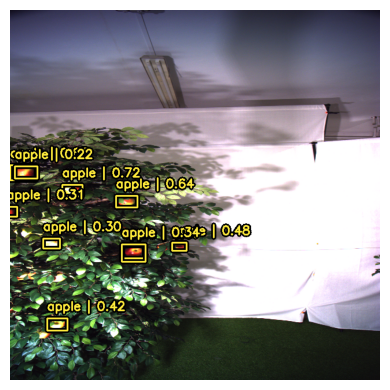

In [40]:
visualization.plot_bounding_box_gallery(
        #load_image(img_path)[tf.newaxis, :],
        img,
        value_range=(0, 255),
        bounding_box_format="xyxy",
        #y_true=y_true, # We don't have true labels at inference
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )